<a href="https://colab.research.google.com/github/Alton1998/CoronoVirus-Image-Project/blob/main/BIOMED_Project_KNN_Alton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomed Project

## Installing Library to work with chest xrays.


In [1]:
!pip -q install torchxrayvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 58.1 MB/s eta 0:00:00


In [2]:
import torchxrayvision as xrv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data.sampler import *

# import torchvision
# import torchvision.models as models

## Downloading covid data set

In [3]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 37.28 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


In [4]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [5]:
MAIN_COVID_DATA_PATH = "covid-chestxray-dataset"
META_DATA_FILE_NAME = "metadata.csv"

In the above data we can see that we have a lot of category of images but for this data set we will focus on Extracting Covid 19 images only

## Reading the metadat provided with this data set.

In [6]:
META_DATA_FILE_PATH = os.path.join(MAIN_COVID_DATA_PATH,META_DATA_FILE_NAME)

In [7]:
meta_data_df = pd.read_csv(META_DATA_FILE_PATH)
FINDINGS_COLUMN = "finding"

In [8]:
meta_data_df[FINDINGS_COLUMN].unique()

array(['Pneumonia/Viral/COVID-19', 'Pneumonia', 'Pneumonia/Viral/SARS',
       'Pneumonia/Fungal/Pneumocystis',
       'Pneumonia/Bacterial/Streptococcus', 'No Finding',
       'Pneumonia/Bacterial/Chlamydophila', 'Pneumonia/Bacterial/E.Coli',
       'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella',
       'Unknown', 'Pneumonia/Lipoid', 'Pneumonia/Viral/Varicella',
       'Pneumonia/Bacterial', 'Pneumonia/Bacterial/Mycoplasma',
       'Pneumonia/Viral/Influenza', 'todo', 'Tuberculosis',
       'Pneumonia/Viral/Influenza/H1N1', 'Pneumonia/Fungal/Aspergillosis',
       'Pneumonia/Viral/Herpes ', 'Pneumonia/Aspiration',
       'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/MERS-CoV',
       'Pneumonia/Bacterial/Staphylococcus/MRSA'], dtype=object)

So the finding we have to target is "Pneumonia/Viral/COVID-19", lets try and find the count for this data

In [9]:
meta_data_df[FINDINGS_COLUMN].value_counts()

Pneumonia/Viral/COVID-19                   584
todo                                        83
Pneumonia                                   81
Pneumonia/Fungal/Pneumocystis               30
Pneumonia/Bacterial/Streptococcus           22
No Finding                                  22
Tuberculosis                                18
Pneumonia/Viral/SARS                        16
Pneumonia/Lipoid                            13
Pneumonia/Bacterial/Mycoplasma              11
Pneumonia/Viral/MERS-CoV                    10
Pneumonia/Bacterial/Klebsiella              10
Pneumonia/Bacterial/Legionella              10
Pneumonia/Bacterial/Nocardia                 8
Pneumonia/Viral/Varicella                    6
Pneumonia/Viral/Influenza                    5
Pneumonia/Bacterial                          4
Pneumonia/Bacterial/E.Coli                   4
Pneumonia/Viral/Herpes                       3
Pneumonia/Bacterial/Chlamydophila            3
Pneumonia/Viral/Influenza/H1N1               2
Pneumonia/Fun

To make life easier lets create an additional column that makes it much easier to understand

In [10]:
meta_data_df["simplified-finding"] = meta_data_df[FINDINGS_COLUMN].apply( lambda x : x.split("/")[-1])

<Axes: title={'center': 'Class Distribution'}>

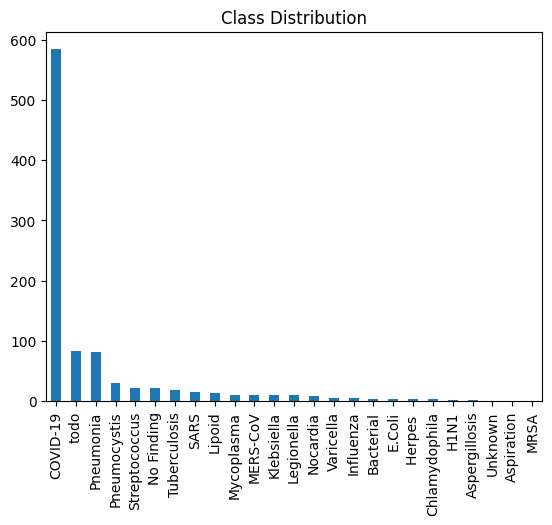

In [11]:
plt.title("Class Distribution")
meta_data_df["simplified-finding"].value_counts().plot(kind="bar")

Lets us see the format these images are in

In [12]:
meta_data_df["file-extension"]=meta_data_df["filename"].apply(lambda x: x.split(".")[-1])

In [13]:
meta_data_df[meta_data_df["simplified-finding"]=="COVID-19"]["file-extension"].value_counts()

jpg     259
png     161
jpeg    139
gz       21
PNG       3
JPG       1
Name: file-extension, dtype: int64

<Axes: title={'center': 'File Extensions used for Covid'}>

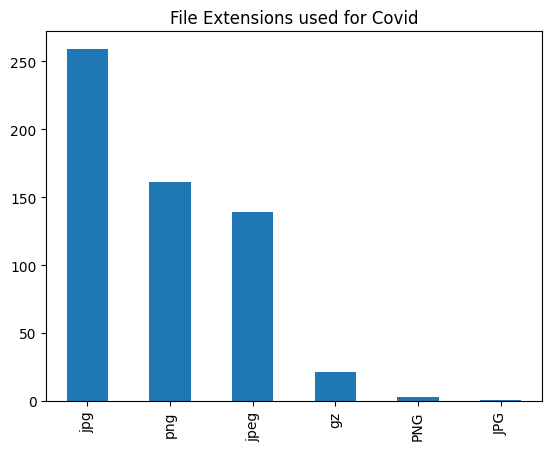

In [14]:
plt.title("File Extensions used for Covid")
meta_data_df[meta_data_df["simplified-finding"]=="COVID-19"]["file-extension"].value_counts().plot(kind="bar")

In [15]:
meta_data_df['view'].unique()

array(['PA', 'AP', 'L', 'Axial', 'AP Supine', 'Coronal', 'AP Erect'],
      dtype=object)

We only care about AP

## Covid DataFrame

In [16]:
covid_df = meta_data_df[(meta_data_df["simplified-finding"]=="COVID-19") & ((meta_data_df["view"]=="AP") | (meta_data_df["view"]=="AP Supine"))]

In [17]:
len(covid_df)

282

In [18]:
covid_df["category"] = covid_df["simplified-finding"]
covid_df["path"] = covid_df["filename"].apply(lambda x : os.path.join("covid-chestxray-dataset","images",x))

In [19]:
covid_df_formatted = covid_df[["category","path"]]

In [20]:
covid_df_formatted

,category,path
34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...
930,COVID-19,covid-chestxray-dataset/images/16953_1_1.jpg
934,COVID-19,covid-chestxray-dataset/images/16892_2_1.png
935,COVID-19,covid-chestxray-dataset/images/16883_1_1.png
937,COVID-19,covid-chestxray-dataset/images/16858_1_1.png


So now we have the covid data we are interested in, we need now  Normal and Bacterial Data

## Installing Kaggle Libraries to Download data from Kaggle

In [21]:
!pip install -q kaggle

In [22]:
from google.colab import files

## Uploading Creds for use

In [23]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naveenamagesbaboo","key":"46f8780f5c42519b041726d591992588"}'}

## Creating Kaggle Directory to Store Credentials

In [24]:
os.getcwd()


'/content'

In [25]:
!mkdir ~/.kaggle

In [26]:
! cp kaggle.json ~/.kaggle/

In [27]:
! chmod 600 ~/.kaggle/kaggle.json

In [28]:
! kaggle datasets list

ref                                                     title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                         DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           1346        143  1.0              
muhammadbinimran/housing-price-prediction-data          Housing Price Prediction Data               763KB  2023-11-21 17:56:32           5640        100  1.0              
fatihilhan/global-superstore-dataset                    Global Superstore Dataset                     3MB  2023-11-16 11:58:36           1656         30  1.0              
joebeachcapital/30000-spotify-songs                     30000 Spotify Songs                           3MB  2023-11-01 06:06:43          1058

In [29]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:19<00:00, 184MB/s]
100% 2.29G/2.29G [00:19<00:00, 126MB/s]


## Unzipping the file so its easy to consume

In [30]:
!unzip  -q chest-xray-pneumonia.zip -d chest-xray-pneumonia

## Traversing chest-xray-pneumonia to get the paths so that we can put that in a data frame and use later

In [31]:
FOLDERS = ["test","train","val"]
categories = []
image_paths = []
for folder in FOLDERS:
  path = os.path.join("chest-xray-pneumonia","chest_xray",folder)
  for currentpath, folders, files in os.walk(path):
      for file in files:
        path = os.path.join(currentpath,file)
        image_paths.append(path)
        category = path.split("/")[3]
        categories.append(category)


In [32]:
chest_xray_df = pd.DataFrame({"category":categories,"path":image_paths})

In [33]:
chest_xray_df["category"].value_counts()

PNEUMONIA    4273
NORMAL       1583
Name: category, dtype: int64

## Combining out Covid and Chest Xrays

In [34]:
final_data = pd.concat([covid_df_formatted,chest_xray_df])

In [35]:
final_data

,category,path
34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...
5851,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5852,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5853,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
5854,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...


## Final Distribution

<Axes: ylabel='category'>

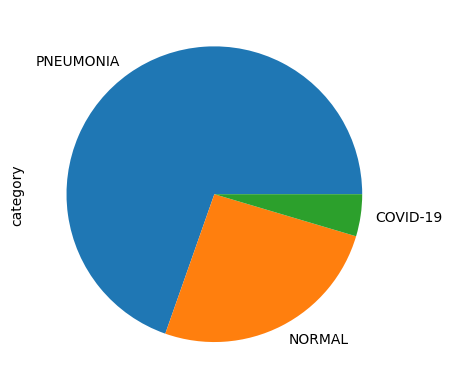

In [36]:
final_data = final_data.reset_index()
final_data["category"].value_counts().plot(kind="pie")

## Performing Transformations

In [37]:
final_data["category"].astype("category")
final_data

,index,category,path
0,34,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
1,35,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
2,36,COVID-19,covid-chestxray-dataset/images/jkms-35-e79-g00...
3,40,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
4,41,COVID-19,covid-chestxray-dataset/images/1-s2.0-S0929664...
...,...,...,...
6133,5851,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6134,5852,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6135,5853,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...
6136,5854,PNEUMONIA,chest-xray-pneumonia/chest_xray/val/PNEUMONIA/...


In [38]:
X=final_data["path"]
y=final_data["category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=101, stratify=y_train, shuffle=True
)

In [39]:
if not os.path.exists("my_data"):
  os.mkdir("my_data")
for folder in FOLDERS:
  path = os.path.join("my_data",folder)
  if not os.path.exists(path):
    os.mkdir(os.path.join("my_data",folder))
  for category in final_data['category'].unique():
    subpath = os.path.join(path,category)
    if not os.path.exists(subpath):
      os.mkdir(subpath)

In [40]:
def data_migrate(dir,X,y):
  i=0
  for path,category in zip(X,y):
    i=i+1
    extension = path.split(".")[-1]
    shutil.copyfile(path, os.path.join("my_data",dir,category,category+"-"+str(i)+"."+extension))


data_migrate("train",X_train,y_train)
data_migrate("test",X_test,y_test)
data_migrate("val",X_val,y_val)

K Nearest Neighbour Pytorch

In [41]:
target_size = (224,224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
# Get the transforms
def load_datasets():

    # Transforms for the image.
    transform = transforms.Compose([
                        transforms.Grayscale(),
                        transforms.Resize(target_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        nn.Flatten()
                ])

    # Define the image folder for each of the data set types
    trainset = datasets.ImageFolder(os.path.join("my_data","train"), transform=transform)
    testset = datasets.ImageFolder(os.path.join("my_data","test"), transform=transform)
    validset = datasets.ImageFolder(os.path.join("my_data","val"), transform=transform)


    # Define indexes and get the subset random sample of each.
    train_dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
    test_dataloader = DataLoader(testset, batch_size=len(testset), shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=len(validset), shuffle=True)

    # Convert data to tensors. This could be made faster.
    x_test = []
    y_test = []
    for idx, (data, tar) in enumerate(test_dataloader):
        x_test = data.squeeze()
        y_test = tar.squeeze()

    x_train = []
    y_train = []
    for idx, (data, tar) in enumerate(train_dataloader):
        x_train = data.squeeze()
        y_train = tar.squeeze()

    x_test = torch.tensor(x_test, device=device)
    y_test = torch.tensor(y_test, device=device)
    x_train = torch.tensor(x_train, device=device)
    y_train = torch.tensor(y_train, device=device)
    return x_train, y_train, x_test, y_test

In [43]:
def knn(x_train, y_train, x_test, k, device, log_interval=100, log=True):

    # Get the amount of images, training images, and image size.
    num_images = x_test.shape[0]
    num_train = y_train.shape[0]
    img_size = x_test.shape[1]

    y_test = torch.zeros((num_images), device=device, dtype=torch.float)

    # For each of the images in the test set
    for test_index in range(0, num_images):

        # Get the image and calculate the distance to every item in the trainset
        test_image = x_test[test_index]
        distances = torch.norm(x_train - test_image, dim=1)

        # Get the top k indexes and get the most used index between them all
        indexes = torch.topk(distances, k, largest=False)[1]
        classes = torch.gather(y_train, 0, indexes)
        mode = int(torch.mode(classes)[0])

        # Save the test value in the index.
        y_test[test_index] = mode

        # Logging since with large sets it may be helpful
        if log:
            if test_index % log_interval == 0:
                print("Currently predicting at test_index = %d" % test_index)

    return y_test

In [44]:
print("Loading data from folders.")
x_train, y_train, x_test, y_test = load_datasets()
print("Loaded train and test with sizes: %s, %s" % (str(x_train.shape), str(x_test.shape)))

Loading data from folders.
Loaded train and test with sizes: torch.Size([3928, 50176]), torch.Size([1228, 50176])


In [51]:
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 25, 37]

correct_vals = []
accuracy = []
best_k = -1
best_correct = 0

for k in k_values:
    pred = knn(x_train, y_train, x_test, k=k, device=device, log=False)
    correct = pred.eq(y_test.view_as(pred)).sum()
    print("K = %d, Correct: %d, Accuracy: %.2f" % (k, correct, 100. * correct / y_test.shape[0]))
    accuracy.append(100. * correct / y_test.shape[0])

K = 1, Correct: 1102, Accuracy: 89.74
K = 2, Correct: 1101, Accuracy: 89.66
K = 3, Correct: 1105, Accuracy: 89.98
K = 4, Correct: 1114, Accuracy: 90.72
K = 5, Correct: 1112, Accuracy: 90.55
K = 6, Correct: 1123, Accuracy: 91.45
K = 7, Correct: 1112, Accuracy: 90.55
K = 8, Correct: 1114, Accuracy: 90.72
K = 9, Correct: 1108, Accuracy: 90.23
K = 10, Correct: 1118, Accuracy: 91.04
K = 13, Correct: 1115, Accuracy: 90.80
K = 25, Correct: 1106, Accuracy: 90.07
K = 37, Correct: 1093, Accuracy: 89.01


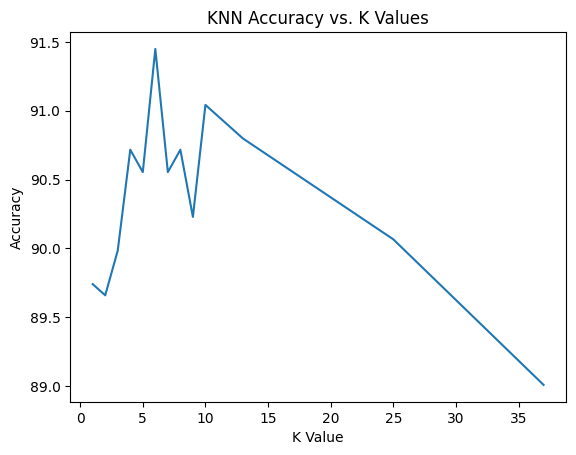

In [53]:
# Create the line plot
plt.plot(k_values, accuracy)

# Set the plot title and labels
plt.title("KNN Accuracy vs. K Values")
plt.xlabel("K Value")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [54]:
pred = knn(x_train, y_train, x_test, k=5, device=device)

Currently predicting at test_index = 0
Currently predicting at test_index = 100
Currently predicting at test_index = 200
Currently predicting at test_index = 300
Currently predicting at test_index = 400
Currently predicting at test_index = 500
Currently predicting at test_index = 600
Currently predicting at test_index = 700
Currently predicting at test_index = 800
Currently predicting at test_index = 900
Currently predicting at test_index = 1000
Currently predicting at test_index = 1100
Currently predicting at test_index = 1200


In [46]:
correct = pred.eq(y_test.to(device).view_as(pred)).sum()
print("Correct predictions: %d/%d, Accuracy: %f" % (correct, y_test.shape[0], 100. * correct / y_test.shape[0]))

Correct predictions: 1112/1228, Accuracy: 90.553749


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
print(classification_report(pred,y_test))
print(confusion_matrix(pred,y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87        47
         1.0       0.74      0.91      0.82       257
         2.0       0.97      0.90      0.94       924

    accuracy                           0.91      1228
   macro avg       0.84      0.92      0.88      1228
weighted avg       0.92      0.91      0.91      1228

[[ 45   1   1]
 [  0 235  22]
 [ 11  81 832]]
